In [2]:
import polars as pl
import glob as glob
import plotnine as pn

In [3]:
glob.glob('data/*')

['data\\lahman_1871-2024_csv', 'data\\league_era.csv', 'data\\league_slg.csv']

In [4]:
(era_data := pl.read_csv("./data/league_era.csv",
                           columns = ['yearID', 'league_wide_ERA', 'lgID', 'DH_status']
                          )
)

yearID,lgID,league_wide_ERA,DH_status
i64,str,f64,str
1964,"""AL""",3.625248,"""No DH"""
1973,"""AL""",3.822629,"""DH"""
2009,"""NL""",4.197515,"""No DH"""
2013,"""AL""",3.993167,"""DH"""
1950,"""NL""",4.14127,"""No DH"""
…,…,…,…
1984,"""NL""",3.592838,"""No DH"""
1995,"""AL""",4.720294,"""DH"""
1992,"""NL""",3.508838,"""No DH"""


In [8]:
era_wide = (era_data
            .pivot( values = 'league_wide_ERA',
                    index=['yearID'],
                    on='lgID'
                  )
            .sort('yearID')
           )
era_wide = era_wide.rename({'AL': 'AL-ERA', 'NL': 'NL-ERA'})

era_wide = era_wide.with_columns((pl.col('AL-ERA')-pl.col('NL-ERA'))
                                    .alias('ERA-diff'))
era_wide.shape
era_long = (
    era_wide
    .unpivot(
        index=["yearID","ERA-diff"],       
        on=["AL-ERA", "NL-ERA"],       
        variable_name="lgID",                  
        value_name="league_wide_ERA"         
    )
    .with_columns(
        pl.col("lgID").str.replace("_ERA", "") 
    )
    .sort(["yearID", "lgID"])
)
era_long.head()

yearID,ERA-diff,lgID,league_wide_ERA
i64,f64,str,f64
1946,0.091605,"""AL-ERA""",3.503345
1946,0.091605,"""NL-ERA""",3.41174
1947,-0.361678,"""AL-ERA""",3.705309
1947,-0.361678,"""NL-ERA""",4.066987
1948,0.327912,"""AL-ERA""",4.282578


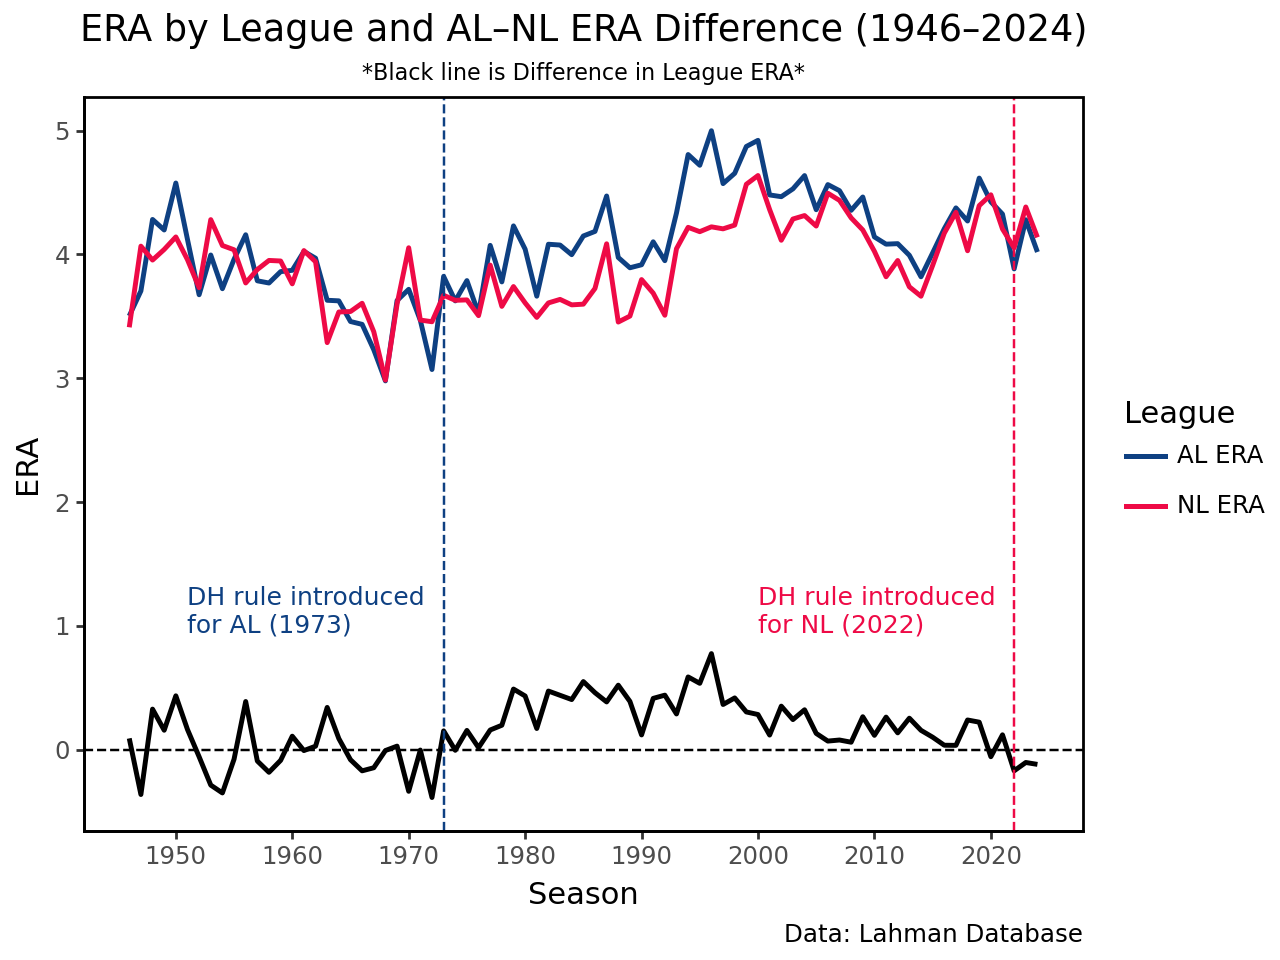

In [9]:
from plotnine import (ggplot, aes, geom_line, geom_hline, geom_vline, annotate, theme_classic, labs,
                        scale_x_continuous, scale_color_manual, theme, element_line, element_rect, element_text
)

(ggplot(era_long, aes(x="yearID")) 
    + geom_line(aes(y="ERA-diff"),
                color="black",
                size=1
               )
    + geom_line(aes(y="league_wide_ERA",
                    color="lgID"),
                    size=1
               )
    + scale_x_continuous( breaks=range(1950,2021,10),
                          labels=lambda l: [str(int(v)) for v in l]
                        )
    + scale_color_manual(
                    values={
                        "AL-ERA": "#0E4082",
                        "NL-ERA": "#EE0A46"
                           },
                    labels={"AL-ERA": "AL ERA", "NL-ERA": "NL ERA"} 
                        )
    + geom_hline(yintercept=0,
                 linetype="dashed",
                 color="black"
                )
    + geom_vline(xintercept=1973,
                 linetype="dashed",
                 color="#0E4082"
                )
    + geom_vline(xintercept=2022,
                 linetype="dashed",
                 color="#EE0A46"
                )
    + annotate("text", x=1951, y=1,
               label="DH rule introduced \nfor AL (1973)\n",
               color="#0E4082", size=9, ha="left"
              )
    + annotate("text", x=2000, y=1,
               label="DH rule introduced \nfor NL (2022)\n",
               color="#EE0A46", size=9, ha="left"
              )
    + theme_classic()
    + theme(panel_border=element_rect(fill=None, color="black", linewidth=1),
            plot_subtitle=element_text(ha="center",size = 8) 
           
           )
    + labs(title="ERA by League and AL–NL ERA Difference (1946–2024)",
           subtitle="*Black line is Difference in League ERA*",
           x="Season",
           y="ERA",
           color="League",
           caption="Data: Lahman Database"
          )
)

In [10]:
(slg_data := pl.read_csv("./data/league_slg.csv",
                           columns = ['yearID', 'league_wide_SLG', 'lgID', 'DH_status']
                          )
)

yearID,lgID,league_wide_SLG,DH_status
i64,str,f64,str
2024,"""NL""",0.403911,"""DH"""
2024,"""AL""",0.394495,"""DH"""
2023,"""AL""",0.411824,"""DH"""
2023,"""NL""",0.416498,"""DH"""
2022,"""AL""",0.391806,"""DH"""
…,…,…,…
1948,"""AL""",0.381639,"""No DH"""
1947,"""NL""",0.390394,"""No DH"""
1947,"""AL""",0.364459,"""No DH"""


In [13]:
slg_wide = (slg_data
            .pivot( values = 'league_wide_SLG',
                    index=['yearID'],
                    on='lgID'
                  )
            .sort('yearID')
           )
slg_wide = slg_wide.rename({'AL': 'AL-SLG', 'NL': 'NL-SLG'})

slg_wide = slg_wide.with_columns((pl.col('AL-SLG')-pl.col('NL-SLG'))
                                    .alias('SLG-diff'))
slg_wide.head()

slg_long = (
    slg_wide
    .unpivot(
        index=["yearID","SLG-diff"],       
        on=["AL-SLG", "NL-SLG"],       
        variable_name="lgID",                  
        value_name="league_wide_SLG"         
    )
    .with_columns(
        pl.col("lgID").str.replace("_SLG", "") 
    )
    .sort(["yearID", "lgID"])
)
slg_long.head()

yearID,SLG-diff,lgID,league_wide_SLG
i64,f64,str,f64
1946,0.008652,"""AL-SLG""",0.364142
1946,0.008652,"""NL-SLG""",0.35549
1947,-0.025936,"""AL-SLG""",0.364459
1947,-0.025936,"""NL-SLG""",0.390394
1948,-0.00091,"""AL-SLG""",0.381639


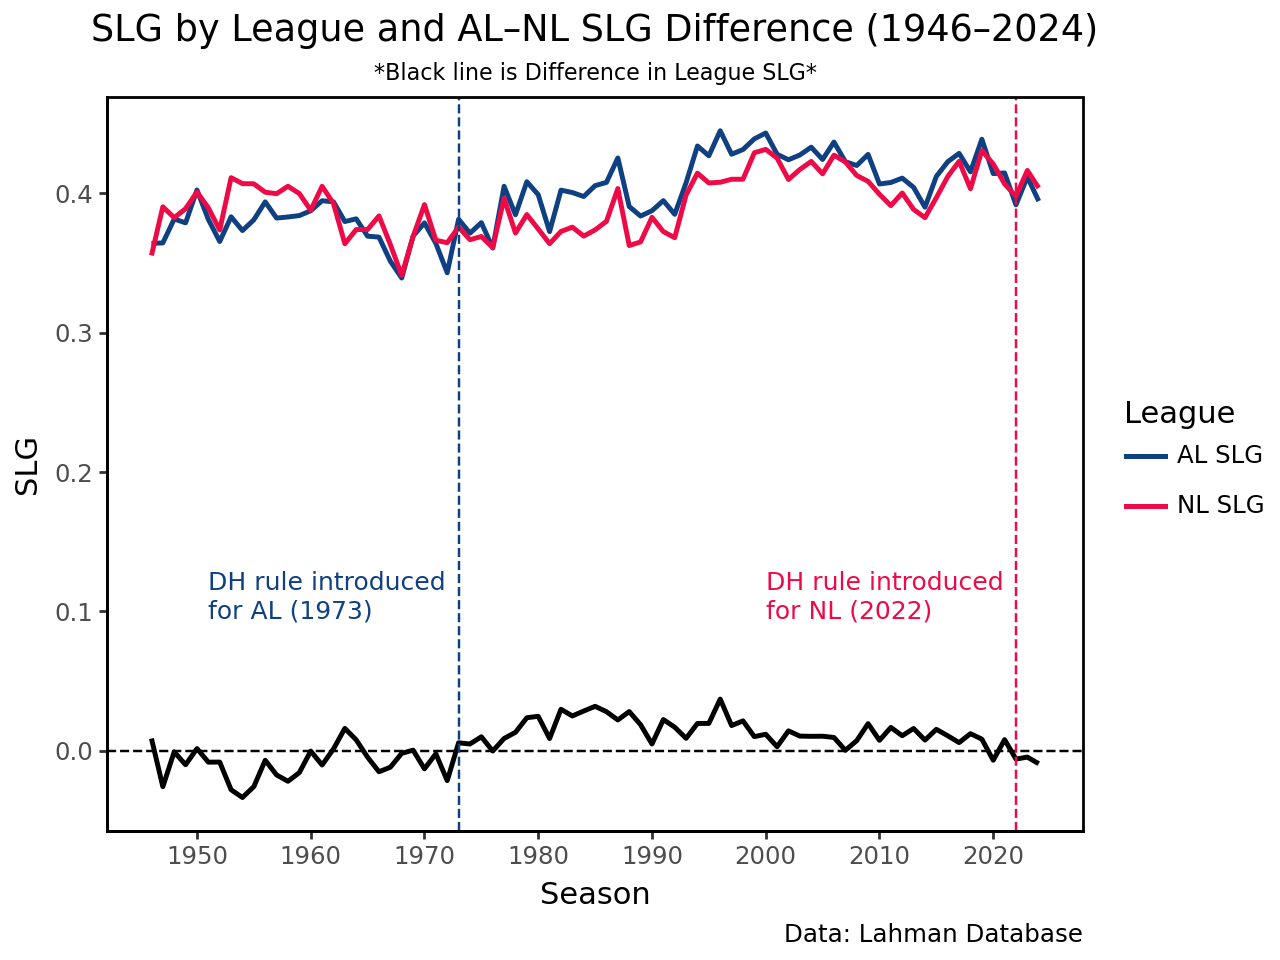

In [18]:
from plotnine import (ggplot, aes, geom_line, geom_hline, geom_vline, annotate, theme_classic, labs,
                        scale_x_continuous, scale_color_manual, theme, element_line, element_rect, element_text
)

(ggplot(slg_long, aes(x="yearID")) 
    + geom_line(aes(y="SLG-diff"),
                color="black",
                size=1
               )
    + geom_line(aes(y="league_wide_SLG",
                    color="lgID"),
                    size=1
               )
    + scale_x_continuous( breaks=range(1950,2021,10),
                          labels=lambda l: [str(int(v)) for v in l]
                        )
    + scale_color_manual(
                    values={
                        "AL-SLG": "#0E4082",
                        "NL-SLG": "#EE0A46"
                           },
                    labels={"AL-SLG": "AL SLG", "NL-SLG": "NL SLG"} 
                        )
    + geom_hline(yintercept=0,
                 linetype="dashed",
                 color="black"
                )
    + geom_vline(xintercept=1973,
                 linetype="dashed",
                 color="#0E4082"
                )
    + geom_vline(xintercept=2022,
                 linetype="dashed",
                 color="#EE0A46"
                )
    + annotate("text", x=1951, y=.1,
               label="DH rule introduced \nfor AL (1973)\n",
               color="#0E4082", size=9, ha="left"
              )
    + annotate("text", x=2000, y=.1,
               label="DH rule introduced \nfor NL (2022)\n",
               color="#EE0A46", size=9, ha="left"
              )
    + theme_classic()
    + theme(panel_border=element_rect(fill=None, color="black", linewidth=1),
            plot_subtitle=element_text(ha="center",size = 8) 
           
           )
    + labs(title="SLG by League and AL–NL SLG Difference (1946–2024)",
           subtitle="*Black line is Difference in League SLG*",
           x="Season",
           y="SLG",
           color="League",
           caption="Data: Lahman Database"
          )
)